In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import LinearRegression

import re
import os
import shutil
import glob
import zipfile
import cv2


# 1.이미지 전처리(OneStep)

## 1.1 이미지 경로

이미지 데이터 타입: uint8


Text(0.5, 1.0, 'Resized Image')

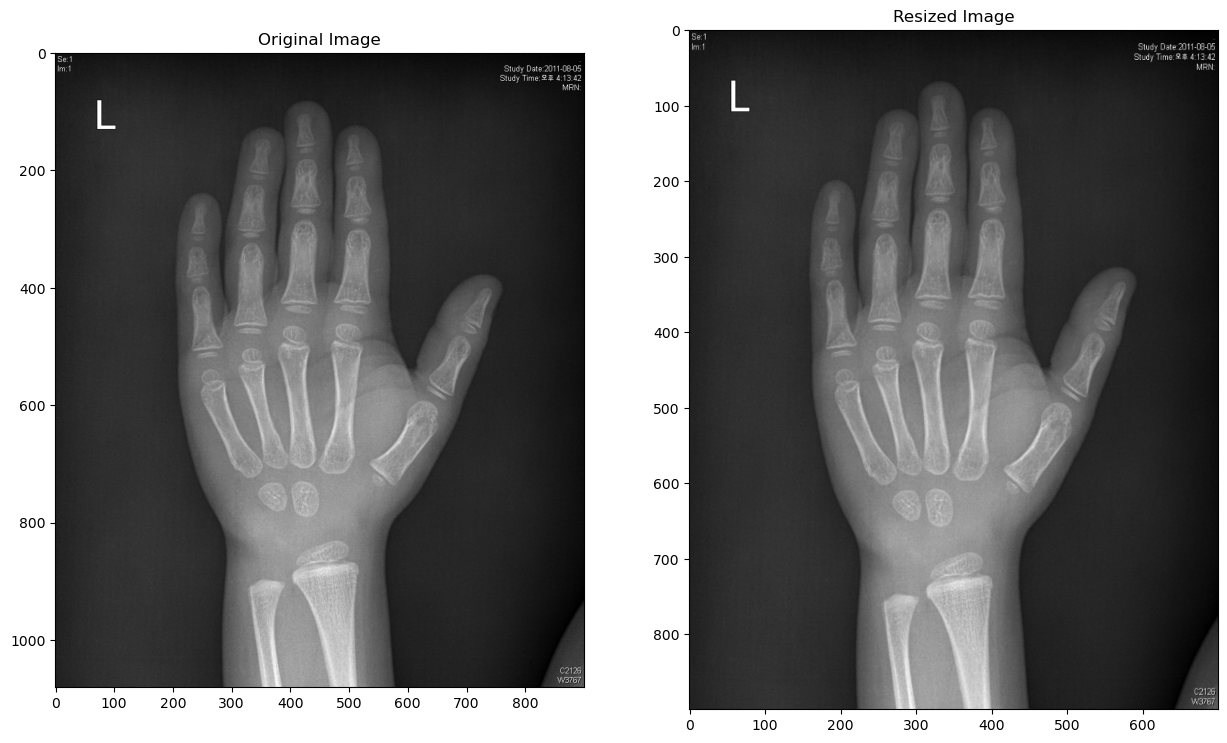

In [3]:
img_path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/Data/Images/"
img_sample = plt.imread(img_path + "1_F.jpg", cv2.IMREAD_GRAYSCALE)

#이미지 데이터 타입 확인
print("이미지 데이터 타입:", img_sample.dtype)

#이미지 사이즈 수정
resized_img=cv2.resize(img_sample, (700, 900))

#이미지 확인
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_sample, "gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(resized_img, "gray")
plt.title("Resized Image")